In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [3]:
print(os.getcwd())
os.chdir("..")
print(os.getcwd())

/home/control/yimzha/Documents/RLWM
/home/control/yimzha/Documents


## Preprocessing

In [4]:
# Read keys for PD patients
with open("/project/3024020.02/data/keys/keysPD.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

# Remove the first row and extract the first UUID for each row
uuids = [line.split()[0] for line in lines[1:] if line.strip()]
print(len(uuids))
print(uuids[-1])

folder_path = '/project/3024020.02/data/extracted_20250301'

7493
a6de0850-bb24-47ae-867d-6724bccee7b6


### RLWM

In [5]:
# Get a list of all CSV files in the folder with "RLWM"
all_rlwm_files = glob.glob(os.path.join(folder_path, "RLWM_*.csv"))
csv_files = [
    f for f in all_rlwm_files
    if any(uuid in os.path.basename(f) for uuid in uuids)
]
print(f'N for all = {len(all_rlwm_files)}')
print(f'N for PD = {len(csv_files)}')

N for all = 284
N for PD = 199


In [38]:
new_df_combined = pd.DataFrame()
exclusion = pd.DataFrame()

for i, csv_file in enumerate(csv_files):
    df = pd.read_csv(csv_file)

    # Get uuid
    filename = os.path.basename(csv_file)
    matched_uuid = [uuid for uuid in uuids if uuid in filename][0]

    # Filter rows where 'trial_mode' is 'learning'
    df = df.loc[df['trial_mode'] == 'learning']
    # Remove "blockId" column
    df = df.drop(columns=['blockId'])
    # Create block number - block incremented by 1 for each new setId / setSize
    df['block'] = ((df['setId'] != df['setId'].shift()) | (df['setSize'] != df['setSize'].shift())).cumsum() - 1
    # Rename stimId based on block and setsize
    df['stimseq'] = df.groupby('block')['stimId'].transform(lambda x: pd.factorize(x)[0])
    # Calculate iteration numbers
    df['iterseq'] = df.groupby(['block', 'stimId']).cumcount() + 1

    # Calculate delays for previous correct trials
    # Get the previous "correct" = 1 index (excluding current row)
    df['prev_correct_index'] = (
        df.groupby(['block', 'stimId'])['correct']
        .transform(lambda x: x.index.to_series().where(x == 1).shift(1).ffill())
    )
    # Calculate delay and replace NaNs with -1
    df['delay_corr'] = (df.index - df['prev_correct_index']).fillna(-1)

    # Calculate leanring stages based on numbers of previous correct trials
    # This "corr_count" also includes the current trial, so if the current trial is the first correct trial per stimulus,
    # The "corr_count" of the current trial will be 1
    df['corr_count'] = (df['correct'] == 1).groupby([df['block'], df['stimId']]).cumsum()
    # First 1-3 correct trials are assigned 1 (early learning)
    # First 7 and after correct trials are assigned 2 (late learning)
    conditions = [
        (df['corr_count'] >= 1) & (df['corr_count'] <= 3),  # Assign 1
        (df['corr_count'] >= 4) & (df['corr_count'] <= 6),  # Assign 2
        (df['corr_count'] >= 7)                             # Assign 3
    ]
    choices = [1, 2, 3]
    df['learning'] = np.select(conditions, choices, default=-1)

    # Select specific columns from df
    selected_columns = df[['block', 'setSize', 'stimseq', 'stimId', 'setId', 'iterseq', 'correct', 
                           'delay_corr', 'corr_count', 'learning', 'rt', 'key_response']]
    # Rename the columns
    new_df = selected_columns.rename(columns={
        'setSize': 'ns',
        'stimId': 'imageseq',
        'setId': 'folderseq',
        'key_response': 'choice'
    }).astype(int)
    # Insert subjectID at the first position
    new_df.insert(0, 'subno', matched_uuid)

    # Concatenate data for each participant into one df
    new_df_combined = pd.concat([new_df_combined, new_df], ignore_index=True)
    # Save preprocessed data
    new_df.to_csv(f'preprocessed/prep_p{i}.csv', index=False)

new_df_combined.to_csv(f'prep_all.csv', index=False)

# Descriptions about new_df structure
# 1. subno - subject ID
# 2. block - block number
# 3. ns - set size, the number of stimuli in each block
# 4. stimseq - stimulus id (transform real stimID to match setsize limit)
# 5. imageseq - actual image number
# 6. folderseq - image category number
# 7. iterseq - iteration number per stimulus, ranging from 1 to 10 for each stimulus
# 8. correct - correctness (1 correct, o incorrect, -1 no response)
# 9. delay_corr - the trial interval since the current stimulus was last reinforced (delay) - is -1 when no correct previous response
# 10. corr_count - the number of [previous(?)] correct responses for each stimulus - tbd
# 11. learning - learning stage (1: early [1-3 correct trials], 2: middle [4-6], 3: late [7-10], -1: the first counter of each stimulus)
# 12. rt - reaction time
# 13. choice - actual action

# tbd
#% 9. corAseqÂ - correct action - need to figure out
#% 13. rew - tbd - correct
#% 15. expe condition - experimental condition (for some data sets) - set to 1
#% 16. pcor - number of previous correct trials for given stimulus (used in logistic regression analysis)
#% 17. delay - delay since last correct trial for same stimulus (same)
#% 18. pchos - number of times this action was previously chosen

### Preprocessing

In [62]:
df = pd.read_csv('prep_all.csv')
# Count sample size
n_subj = df['subno'].nunique()
print(f'Number of all PD participants: {n_subj}')

# 1 subno missing
#subnos_after_step1 = df[df['block'] != 0]['subno'].unique()
#subnos_after_step2 = df[(df['block'] != 0) & (df['corr_count'] != 0)]['subno'].unique()
#removed_subno = list(set(subnos_after_step1) - set(subnos_after_step2))
#print(f"Removed subno：{removed_subno}")

# 1. Remove the first block for every participant (training block)
df = df[df['block'] != 0]

# 2. Restricted to trials for which the subject had already responded correctly to the given stimulus at least once
filtered_df_1 = df[df['corr_count'] != 0]

# 3. Calculate non-response rate & remove participants
proportions = filtered_df_1.groupby('subno')['correct'].apply(lambda x: (x == -1).mean()).reset_index(name='proportion')
mean_prop = proportions['proportion'].mean()
std_prop = proportions['proportion'].std()
print(f"Proportion with no response rate Mean = {mean_prop:.2%}, SD = {std_prop:.2}")

subno_to_remove = proportions[proportions['proportion'] >= 0.2]['subno']
df = df[~df['subno'].isin(subno_to_remove)]
print(f'Number of participants removed based on non response rate: {len(subno_to_remove)}')

# 4. Calculate accuracy & remove participants
filtered_df_2 = df[(df['correct'] != -1) & (df['corr_count'] != 0)]
proportions = filtered_df_2.groupby('subno')['correct'].apply(lambda x: (x == 0).mean()).reset_index(name='proportion')
mean_prop = proportions['proportion'].mean()
std_prop = proportions['proportion'].std()
print(f"Inaccuracy Mean = {mean_prop:.2%}, SD = {std_prop:.2}")

subno_to_remove = proportions[proportions['proportion'] >= 0.33]['subno']
df = df[~df['subno'].isin(subno_to_remove)]
print(f'Number of participants removed based on inaccuracy: {len(subno_to_remove)}')

# 5. Drop blocks where proportions of no responses exceed 33%
# Count, for each participant, how many blocks were removed (i.e. condition is False)
cut_off = 0.33
block_condition = df.groupby(['subno', 'block'])['correct'].apply(
    lambda x: (x == -1).mean() <= cut_off
)
removed_blocks = block_condition.groupby('subno').apply(lambda x: (~x).sum())
print(f"Number of blocks removed per participant: Mean = {removed_blocks.mean()}, SD = {removed_blocks.std()}")

proportion_filter = df.groupby(['subno', 'block'])['correct'].transform(lambda x: (x == -1).mean() <= cut_off)
df = df[proportion_filter]

# 6. Remove trials with no response
removed_trials = df.groupby('subno')['correct'].apply(lambda x: (x == -1).mean())
print(f"Proportion of trials removed per participant: Mean = {removed_trials.mean()}, SD = {removed_trials.std()}")
df = df[df['correct'] != -1]

# 7. Remove trials where RT < 200ms
df = df[df['rt'] > 200]

df.to_csv(f'clean_all.csv', index=False)
n_subj = df['subno'].nunique()
print(f'Number of PD participants after preprocessing: {n_subj}')

Number of all PD participants: 199
Proportion with no response rate Mean = 5.19%, SD = 0.078
Number of participants removed based on non response rate: 9
Inaccuracy Mean = 17.84%, SD = 0.1
Number of participants removed based on inaccuracy: 15
Number of blocks removed per participant: Mean = 0.48, SD = 1.325436384439254
Proportion of trials removed per participant: Mean = 0.0569120598362592, SD = 0.05138899935690556
Number of PD participants after preprocessing: 174


In [63]:
# Get all UUIDs
subno_unique_list = df['subno'].unique().tolist()
if len(subno_unique_list) != n_subj:
    print('Warning!!!!!!!!')

# In case we lose something...
ori_df = df
ori_df.head()

,subno,block,ns,stimseq,imageseq,folderseq,iterseq,correct,delay_corr,corr_count,learning,rt,choice
410,0a5376d0-f95a-4ffc-818f-a132bd9cee8e,1,2,0,3,5,1,0,-1,0,-1,891,1
411,0a5376d0-f95a-4ffc-818f-a132bd9cee8e,1,2,0,3,5,2,1,-1,1,1,803,2
412,0a5376d0-f95a-4ffc-818f-a132bd9cee8e,1,2,1,5,5,1,1,-1,1,1,781,3
413,0a5376d0-f95a-4ffc-818f-a132bd9cee8e,1,2,0,3,5,3,0,2,1,1,654,1
414,0a5376d0-f95a-4ffc-818f-a132bd9cee8e,1,2,1,5,5,2,1,2,2,1,591,3


### Medication status

Notes: 
1. "choice" is MDSUPDRS score
2. total MDSUPDRS score: choice - 1 and sum up
3. <12 = mild, >30 severe

Caution:
1. some MDSUPDRS files are empty
2. Fewer MDSUPDRS files than RLWM data

In [64]:
# MDSUPDRS (some files are empty so.....)
# Initialize dictionary to store results
uuid_sums = {}

# Get a list of all CSV files in the folder with "questionnaires_MDSUPDRS_"
all_mds_files = glob.glob(os.path.join(folder_path, "questionnaires_MDSUPDRS_*.csv"))
print(f"N (all PD patients with MDSUPDRS scores) = {len(all_mds_files)}")

for csv_file in all_mds_files:
    # Extract filename and check against uuids
    filename = os.path.basename(csv_file)
    matched_uuids = [uuid for uuid in subno_unique_list if uuid in filename]
    
    if not matched_uuids:
        continue  # Skip files without matching UUID
    
    # Process the matching UUID
    uuid = matched_uuids[0]
    
    # Process CSV and calculate sum
    df = pd.read_csv(csv_file)

    if "choice" not in df.columns:
        print(f"Warning csv {filename} does not have a choice column and was skipped")
        continue
    
    df["choice"] = df["choice"] - 1
    total_sum = df["choice"].sum()
    
    # Store result in dictionary
    uuid_sums[uuid] = total_sum

print(f"N (PD patients with MDSUPDRS scores & matched preprocessed RLWM data) = {len(uuid_sums)}")

N (all PD patients with MDSUPDRS scores) = 220
Warning csv questionnaires_MDSUPDRS_1f5b6a6f-1101-4c25-876a-ee4a419e1d98.csv does not have a choice column and was skipped
Warning csv questionnaires_MDSUPDRS_bcf1cdf2-27c1-4cd1-af7f-c52a2d687ae8.csv does not have a choice column and was skipped
N (PD patients with MDSUPDRS scores & matched preprocessed RLWM data) = 136


Mean = 16.330882352941178, SD = 8.082347455901898


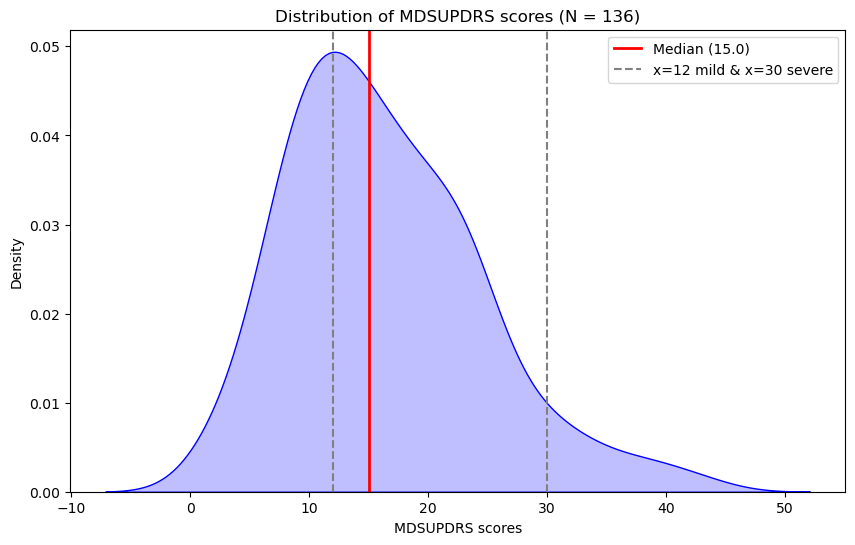

In [86]:
data = np.array(list(uuid_sums.values()))
print(f'Mean = {data.mean()}, SD = {data.std()}')

plt.figure(figsize=(10, 6))
sns.kdeplot(data, fill=True, color='blue')

median = np.median(data)
plt.axvline(median, color='red', linewidth=2, label=f'Median ({median:.1f})')
plt.axvline(12, color='gray', linestyle='--', linewidth=1.5, label='x=12 mild & x=30 severe')
plt.axvline(30, color='gray', linestyle='--', linewidth=1.5)

plt.title(f'Distribution of MDSUPDRS scores (N = {len(uuid_sums)})')
plt.xlabel('MDSUPDRS scores')
plt.ylabel('Density')
plt.legend()
plt.show()

Subjective scales (motor & cognitive)

In [125]:
# Med data for RLWM
# Initialize dictionary to store results
uuid_motor = {}
uuid_cog = {}

# Get a list of all CSV files in the folder with "questionnaires_MDSUPDRS_"
all_mds_files = glob.glob(os.path.join(folder_path, "MEDdata_RLWM*.csv"))
print(f"N (all PD patients with MED data) = {len(all_mds_files)}")

for csv_file in all_mds_files:
    # Extract filename and check against uuids
    filename = os.path.basename(csv_file)
    matched_uuids = [uuid for uuid in subno_unique_list if uuid in filename]
    
    if not matched_uuids:
        continue  # Skip files without matching UUID
    
    # Process the matching UUID
    uuid = matched_uuids[0]
    
    # Process CSV
    df = pd.read_csv(csv_file)

N (all PD patients with MED data) = 283


In [127]:
df['response']

0    {'timeSinceMed': 2, 'motorMed': 2, 'cognitiveM...
Name: response, dtype: object

In [ ]:
raise NotImplementedError("No use for now")
# MED_RLWM
# Get a list of all CSV files in the folder with "MEDdata_RLWM"
all_med_files = glob.glob(os.path.join(folder_path, "MEDdata_RLWM*.csv"))
med_files = [
    f for f in all_med_files
    if any(uuid in os.path.basename(f) for uuid in uuids)
]
print(f'N for all = {len(all_med_files)}')
print(f'N for PD = {len(med_files)}')

## Plots

### Each participant

In [ ]:
raise NotImplementedError("No use for now")

folder_path = '../data/preprocessed'
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

for i, csv_file in enumerate(csv_files):
    df = pd.read_csv(csv_file)
    # Drop blocks where proportions of no responses exceed 30%
    proportion_filter = df.groupby(['subno', 'block'])['correct'].transform(lambda x: (x == -1).mean() <= 0.33)
    df = df[proportion_filter]
    # Remove trials with no response
    df = df[df['correct'] != -1]
    # Calculate the average accuracy
    grouped = df.groupby(['ns', 'iterseq'])['correct'].mean().reset_index()

    # Plot
    plt.figure(figsize=(10, 6))
    for ns_value in grouped['ns'].unique():
        subset = grouped[grouped['ns'] == ns_value]
        plt.plot(subset['iterseq'], subset['correct'], marker='o', linestyle='-', label=f'set size = {ns_value}')

    plt.title(f'Accuracy under different numbers of iterations (participant {i})')
    plt.xlabel('Previous Iterations')
    plt.ylabel('Accuracy')
    plt.legend(title='Set Size')
    plt.show()

NotImplementedError: Modification needed

### All participants

Not a good practice but you need to manually run one of these cells if you want to split the data based on medication status..

In [106]:
# High group
high_df = ori_df
sum_values = list(uuid_sums.values())
median_sum = np.median(sum_values)
selected_uuids = [uuid for uuid, s in uuid_sums.items() if s > 20]
df = high_df[high_df['subno'].isin(selected_uuids)]
n_subj = df['subno'].nunique()
print(f'Number of PD participants with high MDSUPDRS scores: {n_subj}')

Number of PD participants with high MDSUPDRS scores: 38


In [119]:
# Low group
low_df = ori_df
sum_values = list(uuid_sums.values())
median_sum = np.median(sum_values)
selected_uuids = [uuid for uuid, s in uuid_sums.items() if s <= 10]
df = low_df[low_df['subno'].isin(selected_uuids)]
n_subj = df['subno'].nunique()
print(f'Number of PD participants with low MDSUPDRS scores: {n_subj}')

Number of PD participants with low MDSUPDRS scores: 36


#### Win-stay lose-shift

In [ ]:
raise NotImplementedError("Modification needed")
win_stay = []
lose_shift = []
n_lag = 5

for lag in range(1, n_lag+1):
    df_lag = df.copy()
    # Move "correct" down for "lag" - to directly compare
    df_lag[f'corr_lag{lag}'] = df_lag.groupby(['subno', 'block', 'stimseq'])['correct'].shift(lag)
    # Move "choice" down for "lag" and compare
    df_lag[f'stay_lag{lag}'] = (
        df.groupby(['subno', 'block', 'stimseq'])['choice']
        .transform(lambda x: (x == x.shift(lag)).astype(float))
    )
    df_lag = df_lag.dropna()
    # win stay
    mean_stay_corr = df_lag[df_lag[f'corr_lag{lag}'] == 1][f'stay_lag{lag}'].mean()
    win_stay.append(mean_stay_corr)
    # lose shift
    mean_stay_incorr = df_lag[df_lag[f'corr_lag{lag}'] == 0][f'stay_lag{lag}'].mean()
    lose_shift.append(1-mean_stay_incorr)


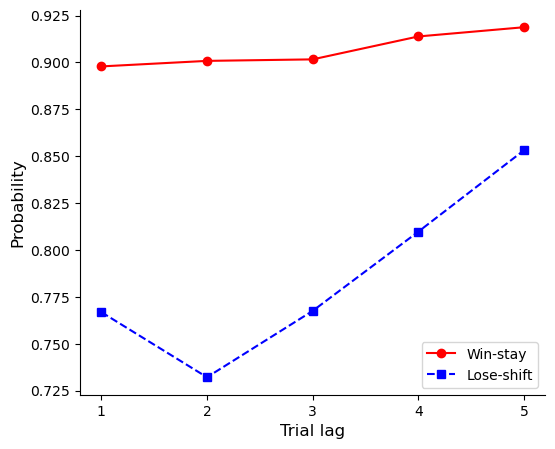

In [ ]:
raise NotImplementedError("Modification needed")
lags = [i+1 for i in range(n_lag)]   

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(lags, win_stay, 'o-', color='red', label='Win-stay')
ax.plot(lags, lose_shift, 's--', color='blue', label='Lose-shift')

ax.set_xlabel('Trial lag', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.set_xticks(lags)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='best', fontsize=10)

plt.show()

In [ ]:
raise NotImplementedError("Modification needed")
df_lag.to_csv(f'../../data/df_lag.csv', index=False)
df_lag

,subno,block,ns,stimseq,imageseq,folderseq,iterseq,correct,delay_corr,corr_count,learning,rt,choice,corr_lag4,stay_lag4
32,0,1,2,0,3,5,5,1,-1,1,1,1255,2,0.0,0.0
35,0,1,2,0,3,5,6,1,3,2,1,1054,2,0.0,0.0
36,0,1,2,0,3,5,7,1,1,3,1,1033,2,0.0,0.0
37,0,1,2,1,5,5,6,1,-1,1,1,607,3,0.0,0.0
38,0,1,2,1,5,5,7,1,1,2,1,607,3,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3845,9,10,4,2,2,9,9,1,6,8,3,769,3,1.0,1.0
3846,9,10,4,1,4,9,10,0,5,1,1,321,1,0.0,1.0
3847,9,10,4,3,3,9,10,0,-1,0,-1,429,1,0.0,1.0
3848,9,10,4,2,2,9,10,1,3,9,3,699,3,1.0,1.0


#### Speed-accuracy trade-off

In [ ]:
conditions = [
    (0, None), (1, None),  # Overall
    (0, 1), (1, 1),        # Learning 1
    (0, 3), (1, 3)         # Learning 3
]

# Generate data series
rts = [
    df[(df['correct'] == c) & (df['learning'] == l if l else df['correct'] == c)]['rt']
    for c, l in conditions
]

# Calculate means and SEMs
means = [rt.mean() for rt in rts]
ses = [rt.sem() for rt in rts]

# Visualization parameters
bar_width = 0.2
x_pos = [0.4, 0.6, 0.9, 1.1, 1.4, 1.6]  # Three groups
colors = ['#1f77b4', '#7ec8e3'] * 3     # Alternate colors for incorrect/correct
group_labels = ['All trials', 'Early learning', 'Late learning']
xticks_pos = [0.5, 1.0, 1.5]            # Group label centers

plt.figure(figsize=(10, 8))

# Create bars with error caps
bars = plt.bar(x_pos, means, width=bar_width,
               yerr=ses, capsize=7, color=colors, 
               edgecolor='none')

# Set up axes
plt.xticks(xticks_pos, group_labels, fontsize=14)
plt.ylabel('Reaction time (ms)', fontsize=14)
plt.ylim(0, max(means) * 1.5)
plt.yticks(fontsize=14)
plt.gca().spines[['top', 'right']].set_visible(False)

# Statistical annotations
groups = [(0,1), (2,3), (4,5)]  # Bar indices for each group
for idx, (i,j) in enumerate(groups):
    t_stat, p = stats.ttest_ind(rts[i], rts[j], equal_var=False)
    
    # Determine significance stars
    if p < 0.001:
        stars = '***'
    elif p < 0.01:
        stars = '**'
    elif p < 0.05:
        stars = '*'
    else:
        stars = 'ns'
    
    # Calculate annotation position
    y_base = max(means[i] + ses[i], means[j] + ses[j])
    line_y = y_base * 1.1
    text_y = line_y * 1.05
    
    # Draw significance markers
    plt.plot([x_pos[i], x_pos[j]], [line_y]*2, '-', color='k', lw=1)
    plt.text(np.mean([x_pos[i], x_pos[j]]), text_y, 
             f'{stars}\n$p$ = {p:.3f}', 
             ha='center', va='bottom', fontsize=12)

# Create simplified legend
legend_elements = [
    plt.Rectangle((0,0),1,1, color='#1f77b4', label='Incorrect'),
    plt.Rectangle((0,0),1,1, color='#7ec8e3', label='Correct')
]
plt.legend(handles=legend_elements,
           frameon=False,
           bbox_to_anchor=(1, 0.9),
           fontsize=14)

plt.tight_layout()
plt.show()

#### Set size * Iterations

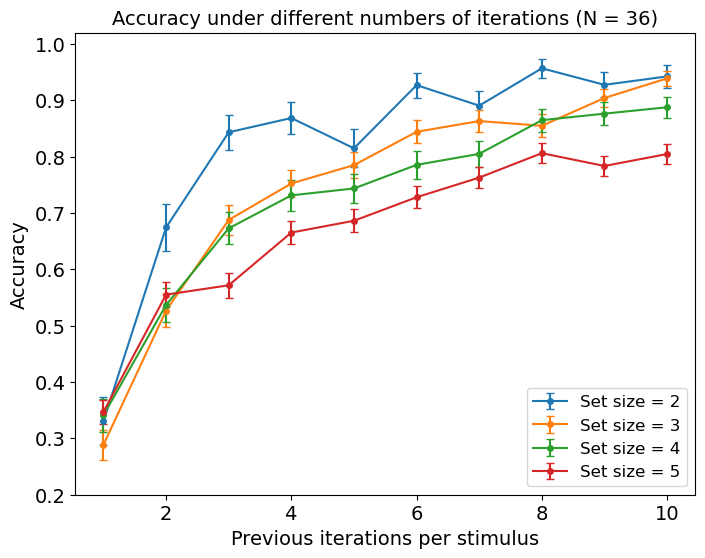

In [120]:
# Calculate the average accuracy
grouped = df.groupby(['ns', 'iterseq'])['correct'].agg(['mean', 'sem']).reset_index()

# Plot
plt.figure(figsize=(8, 6))
for i, ns_value in enumerate(grouped['ns'].unique()):
    subset = grouped[grouped['ns'] == ns_value]
    
    errorbar_plot = plt.errorbar(
        x=subset['iterseq'],
        y=subset['mean'],
        yerr=subset['sem'],
        marker='o',
        linestyle='-',
        markersize=4,
        label=f'Set size = {ns_value}',
        capsize=3
    )

plt.title(f'Accuracy under different numbers of iterations (N = {n_subj})', fontsize=14)
plt.xlabel('Previous iterations per stimulus', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.2, 1.02)
plt.show()

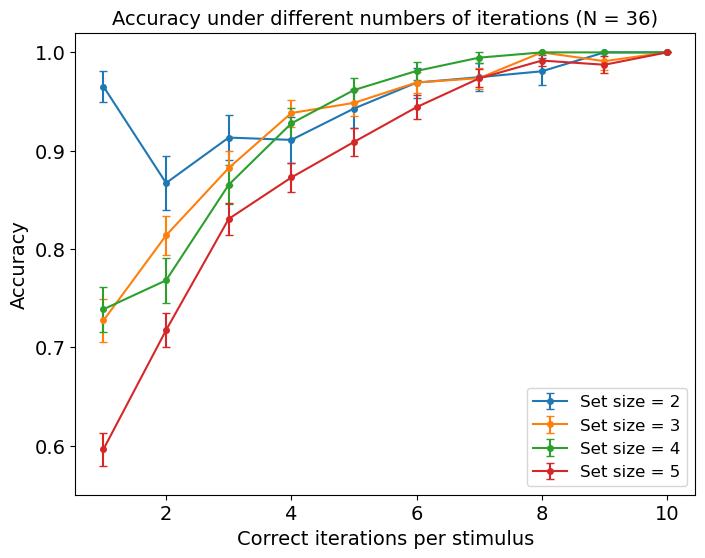

In [121]:
df_1 = df[df['corr_count'] != 0]
# Calculate the average accuracy
grouped = df_1.groupby(['ns', 'corr_count'])['correct'].agg(['mean', 'sem']).reset_index()

# Plot
plt.figure(figsize=(8, 6))
for i, ns_value in enumerate(grouped['ns'].unique()):
    subset = grouped[grouped['ns'] == ns_value]
    errorbar_plot = plt.errorbar(
        x=subset['corr_count'],
        y=subset['mean'],
        yerr=subset['sem'],
        marker='o',
        linestyle='-',
        markersize=4,
        label=f'Set size = {ns_value}',
        capsize=3
    )

plt.title(f'Accuracy under different numbers of iterations (N = {n_subj})', fontsize=14)
plt.xlabel('Correct iterations per stimulus', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.55, 1.02)
plt.show()

#### Set size * Delay

/scratch/yimzha/slurm_job_47044978/ipykernel_2278100/1063399598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['delay_grp'] = np.where(df_2['delay_corr'] >= 5, '5+', df_2['delay_corr'])


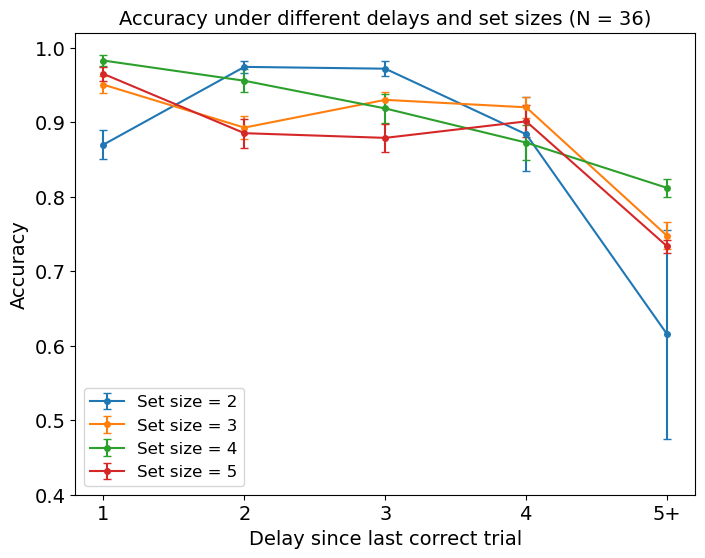

In [122]:
# Remove trials where delays are -1
df_2 = df[df['delay_corr'] != -1]
# All values higher than n in "delay_corr" are integrated into the same group
df_2['delay_grp'] = np.where(df_2['delay_corr'] >= 5, '5+', df_2['delay_corr'])
# Calculate the average accuracy
grouped = df_2.groupby(['ns', 'delay_grp'])['correct'].agg(['mean', 'sem']).reset_index()

# Plot
plt.figure(figsize=(8, 6))
for i, ns_value in enumerate(grouped['ns'].unique()):
    subset = grouped[grouped['ns'] == ns_value]
    errorbar_plot = plt.errorbar(
        x=subset['delay_grp'],
        y=subset['mean'],
        yerr=subset['sem'],
        marker='o',
        linestyle='-',
        markersize=4,
        label=f'Set size = {ns_value}',
        capsize=3
    )

plt.title(f'Accuracy under different delays and set sizes (N = {n_subj})', fontsize=14)
plt.xlabel('Delay since last correct trial', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.4, 1.02)
plt.show()

#### Learning stage * Delay

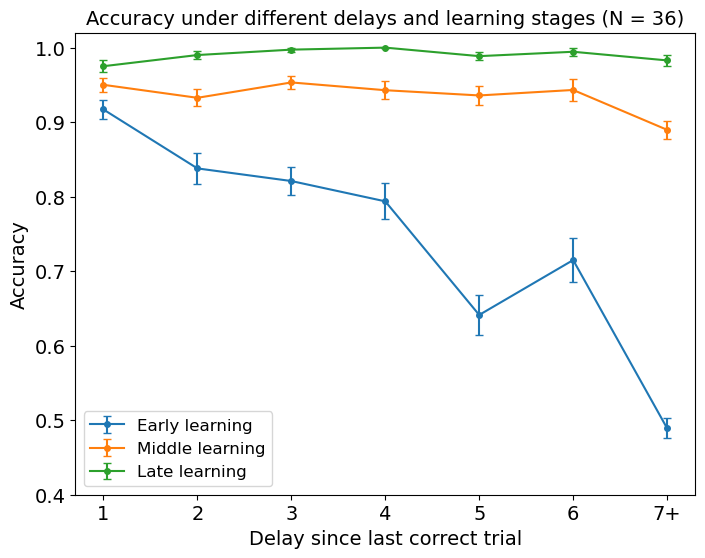

In [123]:
# Remove trials where learning and delay are -1
df_3 = df[df['delay_corr'] != -1]
df_3 = df_3[df_3['learning'] != -1]
# All values higher than n in "delay_corr" are integrated into the same group
df_3['delay_grp'] = np.where(df_3['delay_corr'] >= 7, '7+', df_3['delay_corr'])
# Calculate the average accuracy
grouped = df_3.groupby(['learning', 'delay_grp'])['correct'].agg(['mean', 'sem']).reset_index()

# Plot
labels = ['Early learning', 'Middle learning', 'Late learning']
plt.figure(figsize=(8, 6))
for i, ns_value in enumerate(grouped['learning'].unique()):
    subset = grouped[grouped['learning'] == ns_value]
    errorbar_plot = plt.errorbar(
        x=subset['delay_grp'],
        y=subset['mean'],
        yerr=subset['sem'],
        marker='o',
        linestyle='-',
        markersize=4,
        label=f'{labels[i]}',
        capsize=3
    )

plt.title(f'Accuracy under different delays and learning stages (N = {n_subj})', fontsize=14)
plt.xlabel('Delay since last correct trial', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.4, 1.02)
plt.show()

#### Learning stage * Set size

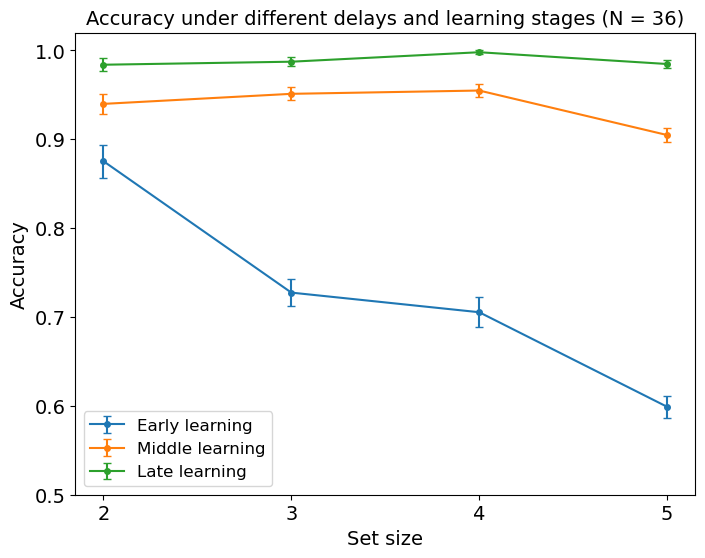

In [124]:
# Remove trials where learning and delay are -1
df_3 = df[df['delay_corr'] != -1]
df_3 = df_3[df_3['learning'] != -1]
# Calculate the average accuracy
grouped = df_3.groupby(['learning', 'ns'])['correct'].agg(['mean', 'sem']).reset_index()

# Plot
labels = ['Early learning', 'Middle learning', 'Late learning']
plt.figure(figsize=(8, 6))
for i, ns_value in enumerate(grouped['learning'].unique()):
    subset = grouped[grouped['learning'] == ns_value]
    errorbar_plot = plt.errorbar(
        x=subset['ns'],
        y=subset['mean'],
        yerr=subset['sem'],
        marker='o',
        linestyle='-',
        markersize=4,
        label=f'{labels[i]}',
        capsize=3
    )

plt.xticks(
    ticks=[2, 3, 4, 5],
    labels=['2', '3', '4', '5'],
    fontsize=14
)

plt.title(f'Accuracy under different delays and learning stages (N = {n_subj})', fontsize=14)
plt.xlabel('Set size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.yticks(fontsize=14)
plt.ylim(0.5, 1.02)
plt.show()

### Predicted accuracy
Not a good practice but you need to fit regression models in R before runnign following codes

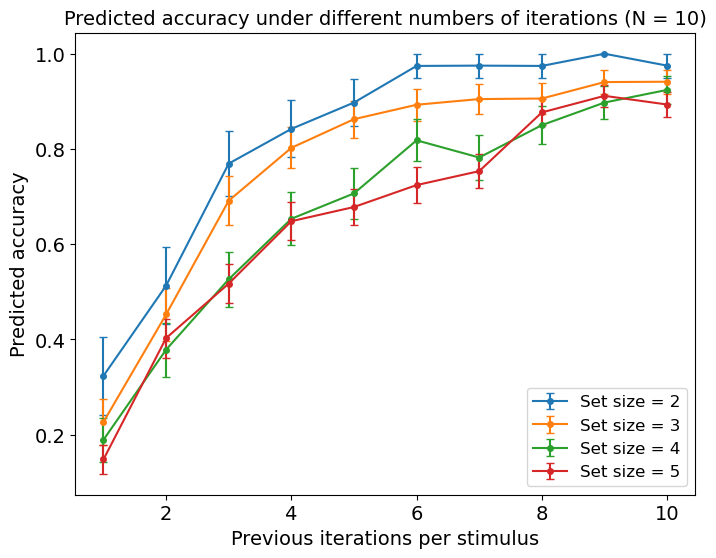

In [ ]:
raise NotImplementedError("Modification needed")
df = pd.read_csv('../data/predicted_all.csv') # no need to preprocess again; already clean

# Calculate the average accuracy
grouped = df.groupby(['ns', 'iterseq'])['predicted_correct'].agg(['mean', 'sem']).reset_index()

# Plot
plt.figure(figsize=(8, 6))
for i, ns_value in enumerate(grouped['ns'].unique()):
    subset = grouped[grouped['ns'] == ns_value]
    
    errorbar_plot = plt.errorbar(
        x=subset['iterseq'],
        y=subset['mean'],
        yerr=subset['sem'],
        marker='o',
        linestyle='-',
        markersize=4,
        label=f'Set size = {ns_value}',
        capsize=3
    )

plt.title(f'Predicted accuracy under different numbers of iterations (N = {n_subj})', fontsize=14)
plt.xlabel('Previous iterations per stimulus', fontsize=14)
plt.ylabel('Predicted accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()